# Machine learning in Spark
![bbc logo](https://www.nwcu.police.uk/wp-content/uploads/2013/05/BBC-News.png)

Section influenced by [this analysis of twitter data](https://wesslen.github.io/twitter/predicting_twitter_profile_location_with_pyspark/)

## Meet Greg

![greg](img/thinking.jpeg)

## Greg's life is full of pain

Greg has become really tired of his boss asking him to do all these random things.<br>
**First** she had him learn Object Oriented Programming and it's been downhill ever since.<br>
**Now** she's wanting him to send her a summary of political news from the BBC each day.<br>
The problem is it takes him hours just to sort through the BBC website to get *just* the political articles that interest her.

### Create spark context

In [1]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
spark

In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

### Read in our dataset of articles

In [4]:
bbc = spark.read.csv(path='data/bbc-text.csv', sep=',',
                     encoding='UTF-8', header=True, inferSchema=True)

In [5]:
def show(df, n=5):
    return df.limit(n).toPandas()

### Do some basic data exploration

In [6]:
bbc.columns

['category', 'text']

In [7]:
bbc.dtypes

[('category', 'string'), ('text', 'string')]

In [8]:
bbc.printSchema()

root
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)



In [9]:
bbc.limit(10).toPandas()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [10]:
bbc.count()

2225

In [11]:
bbc.groupBy('category').count().show()

+-------------+-----+
|     category|count|
+-------------+-----+
|        sport|  511|
|     politics|  417|
|entertainment|  386|
|     business|  510|
|         tech|  401|
+-------------+-----+



In [12]:
# Create a new column of target "politics"
from pyspark.sql.functions import when, col
bbc = bbc.withColumn("label",
                     (when(col("category").like("%politics%"), 1)
                      .otherwise(0)))

In [13]:
# drop original target column
bbc = bbc.drop(bbc.category)

In [14]:
show(bbc, 10)

,text,label
0,tv future in the hands of viewers with home th...,0
1,worldcom boss left books alone former worldc...,0
2,tigers wary of farrell gamble leicester say ...,0
3,yeading face newcastle in fa cup premiership s...,0
4,ocean s twelve raids box office ocean s twelve...,0
5,howard hits back at mongrel jibe michael howar...,1
6,blair prepares to name poll date tony blair is...,1
7,henman hopes ended in dubai third seed tim hen...,0
8,wilkinson fit to face edinburgh england captai...,0
9,last star wars not for children the sixth an...,0


## Machine Learning in Spark

Spark's [documentation](https://spark.apache.org/docs/2.2.0/ml-guide.html#mllib-main-guide) is fairly straight forward!  Let's take a look. It shouldn't look *too* different than `sklearn`

### Data prep pipeline

In [15]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer


# regular expression tokenizer
regex_tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http", "https", "amp", "rt", "t", "c", "can"]
stopwords_remover = (StopWordsRemover(inputCol="words", outputCol="filtered")
                                     .setStopWords(add_stopwords))

# bag of words count
count_vectors = CountVectorizer(inputCol="filtered", outputCol="features",
                                vocabSize=10000, minDF=5)

In [16]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regex_tokenizer, stopwords_remover, count_vectors])

# Fit the pipeline to training documents.
pipeline_fit = pipeline.fit(bbc)
dataset = pipeline_fit.transform(bbc)

In [17]:
training_data, test_data = dataset.randomSplit([0.7, 0.3], seed=100)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 1561
Test Dataset Count: 664


### Logistic Regression

In [18]:
from pyspark.ml.classification import LogisticRegression
# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3,
                        elasticNetParam=0, family="binomial")

# Train model with Training Data
lr_model = lr.fit(training_data)

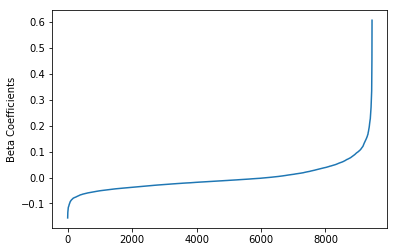

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

beta = np.sort(lr_model.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

### Summary has many components one can call

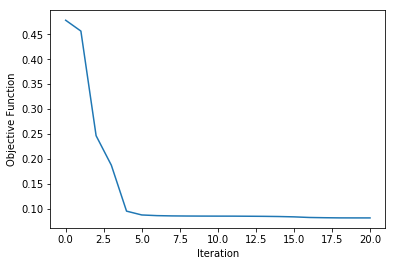

In [20]:
# Extract the summary from the returned LogisticRegressionModel instance trained
training_summary = lr_model.summary

# Obtain the objective per iteration
objective_history = training_summary.objectiveHistory
plt.plot(objective_history)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

areaUnderROC: 0.9999318102470106


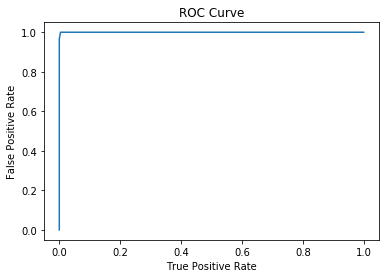

In [21]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(training_summary.areaUnderROC))

#training_summary.roc.show(n=10, truncate=15)
roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

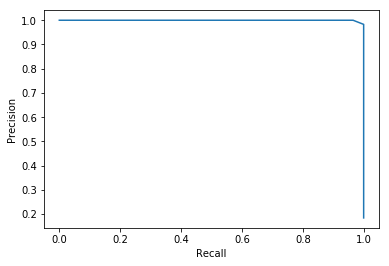

In [22]:
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

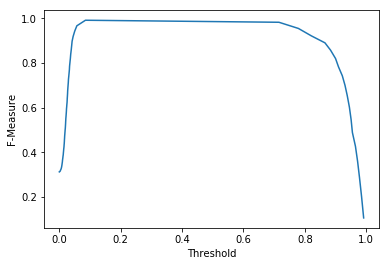

In [24]:
# Set the model threshold to maximize F-Measure
# training_summary.fMeasureByThreshold.show(n=10, truncate = 15)
f = training_summary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

### Evaluate on test data

In [25]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lr_model.transform(test_data)

predictions.select("text","probability").show(n=10, truncate=40)

+----------------------------------------+----------------------------------------+
|                                    text|                             probability|
+----------------------------------------+----------------------------------------+
|2d metal slug offers retro fun like s...|[0.9804110787644086,0.019588921235591...|
|a year to remember for irish there us...|[0.9971249956337924,0.002875004366207...|
|a-listers flock to gervais sitcom hol...|[0.9802504324750112,0.01974956752498866]|
|aaliyah claim dismissed by court late...|[0.9607748047895676,0.039225195210432...|
|actress roberts takes spider role act...|[0.9728119265594252,0.027188073440574...|
|adventure tale tops awards young book...|[0.9765669471450193,0.02343305285498065]|
|african double in edinburgh world 500...|[0.9705370095883613,0.02946299041163871]|
|aids and climate top davos agenda cli...|[0.45518147294539374,0.5448185270546063]|
|ajax refuse to rule out jol move ajax...|[0.981080418156163,0.0189195818438

In [26]:
# predictions object is a dataframe, but with some other options
predictions.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [27]:
(predictions.filter(predictions['prediction'] == 1)
            .select("text", "probability", "label", "prediction")
            .orderBy("probability", ascending=False)
            .show(n=20, truncate=30))

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|uk youth  interested  in po...|[0.4920116864757073,0.50798...|    1|       1.0|
|nuclear dumpsite  plan atta...|[0.48730602499976905,0.5126...|    1|       1.0|
|end bush  denial  blair tel...|[0.4699202484721018,0.53007...|    1|       1.0|
|tory  stalking horse  meyer...|[0.4675499884893308,0.53245...|    1|       1.0|
|labour trio  had vote-rig f...|[0.4661237332865865,0.53387...|    1|       1.0|
|aids and climate top davos ...|[0.45518147294539374,0.5448...|    0|       1.0|
|games enter the classroom v...|[0.4511822517208836,0.54881...|    0|       1.0|
|uk  needs true immigration ...|[0.45042819009705903,0.5495...|    1|       1.0|
|few ready  for information ...|[0.44380016309838305,0.5561...|    1|       1.0|
|kennedy predicts bigger tur

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(training_summary.areaUnderROC))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.9999318102470106
Test: Area Under ROC: 0.9947692530609288


### Naive Bayes
#### Specify and fit the model

In [30]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# train the model
model = nb.fit(training_data)

#### Evaluate Naive Bayes

In [31]:
# select example rows to display.
predictions = model.transform(test_data)
(predictions.filter(predictions['prediction'] == 1)
            .select("text", "probability", "label", "prediction")
            .orderBy("probability", ascending=False)
            .show(n=20, truncate=30))

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|world leaders gather to fac...|[0.3234856203600564,0.67651...|    0|       1.0|
|uganda bans vagina monologu...|[0.08546930870003139,0.9145...|    0|       1.0|
|pension hitch for long-livi...|[0.07509543148569661,0.9249...|    0|       1.0|
|sa unveils  more for all  b...|[0.0028957497589567247,0.99...|    0|       1.0|
|parents face video game les...|[0.002311431605911251,0.997...|    0|       1.0|
|cuba winds back economic cl...|[8.617390269062324E-5,0.999...|    0|       1.0|
|uk helps raped rwandan wome...|[2.5209046203289186E-5,0.99...|    1|       1.0|
|eu aiming to fuel developme...|[1.5309069683180838E-5,0.99...|    0|       1.0|
|mp attacked by muggers in k...|[6.849118591240458E-6,0.999...|    1|       1.0|
|bush to outline  toughest  

### Decision Tree
#### Fit model

In [32]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dt_model = dt.fit(training_data)

In [35]:
print("numNodes =", dt_model.numNodes)
print("depth =", dt_model.depth)

numNodes = 13
depth = 3


#### Evaluate Decision Tree

In [36]:
predictions = dt_model.transform(test_data)

(predictions.filter(predictions['prediction'] == 0)
            .select("text", "probability", "label", "prediction")
            .orderBy("probability", ascending=False)
            .show(n=10, truncate=30))

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|custody death rate  shocks ...|                     [1.0,0.0]|    1|       0.0|
|car giant hit by mercedes s...|[0.9397865853658537,0.06021...|    0|       0.0|
|download chart debut is del...|[0.9397865853658537,0.06021...|    0|       0.0|
|cabs collect mountain of mo...|[0.9397865853658537,0.06021...|    0|       0.0|
|apple sues to stop product ...|[0.9397865853658537,0.06021...|    0|       0.0|
|camera phones are  must-hav...|[0.9397865853658537,0.06021...|    0|       0.0|
|bank voted 8-1 for no rate ...|[0.9397865853658537,0.06021...|    0|       0.0|
|camera phones are  must-hav...|[0.9397865853658537,0.06021...|    0|       0.0|
|battered dollar hits anothe...|[0.9397865853658537,0.06021...|    0|       0.0|
|campbell rescues arsenal so

In [37]:
# Evaluate model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.615598058393103


### Random Forest
#### Specify model

In [40]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = (RandomForestClassifier(labelCol="label",
                             featuresCol="features",
                             numTrees=100,
                             maxDepth=4,
                             maxBins=32))

# Train model with Training Data
rf_model = rf.fit(training_data)

#### Score and evaluate Random Forest

In [41]:
# Score test Data
predictions = rf_model.transform(test_data)

(predictions.filter(predictions['prediction'] == 1)
            .select("text", "probability", "label", "prediction")
            .orderBy("probability", ascending=False)
            .show(n=10, truncate=30))

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|campaign  cold calls  quest...|[0.4995448345980653,0.50045...|    1|       1.0|
|election deal faltered over...|[0.49815015777530697,0.5018...|    1|       1.0|
|campbell: e-mail row  silly...|[0.4875064695286113,0.51249...|    1|       1.0|
|taxes must be trusted - ken...|[0.4834578577984889,0.51654...|    1|       1.0|
|kennedy questions trust of ...|[0.48230053613710067,0.5176...|    1|       1.0|
|choose hope over fear - ken...|[0.4773255320823134,0.52267...|    1|       1.0|
|kilroy launches  veritas  p...|[0.4735754990028187,0.52642...|    1|       1.0|
|women mps reveal sexist tau...|[0.4710989537495881,0.52890...|    1|       1.0|
|ukip s secret weapon  by an...|[0.4672154812088498,0.53278...|    1|       1.0|
|parties warned over  grey v

In [42]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9864667101354777


### Implementing grid search with `CrossValidator` in pyspark

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [50, 100, 200])  # number of trees
              .addGrid(rf.maxDepth, [3, 4, 5])  # maximum depth
#             .addGrid(rf.maxBins, [24, 32, 40]) #Number of bins
              .build())

# Create 5-fold CrossValidator
cv = (CrossValidator(estimator=rf,
                     estimatorParamMaps=param_grid,
                     evaluator=evaluator,
                     numFolds=5))

# Run cross validations
cv_model = cv.fit(training_data)

# Use test set here so we can measure the accuracy of our model on new data
predictions = cv_model.transform(test_data)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9878866912989934


# Building a Movie Recommendation System in PySpark - Lab Code-along
![images of vhs tapes on shelf](img/movies.jpg)

## Introduction

In this last lab, we will implement a a movie recommendation system using Alternating Least Squares (ALS) in Spark programming environment.<br> Spark's machine learning libraray `ml` comes packaged with a very efficient imeplementation of ALS algorithm. 

The lab will require you to put into pratice your spark programming skills for creating and manipulating pyspark DataFrames. We will go through a step-by-step process into developing a movie recommendation system using ALS and pyspark using the MovieLens Dataset.

Note: You are advised to refer to [PySpark Documentation](http://spark.apache.org/docs/2.2.0/api/python/index.html) heavily for completing this lab as it will introduce a few new methods. 

## Objectives

You will be able to:

* Identify the key components of the ALS 
* Demonstrate an understanding on how recommendation systems are being used for personalization of online services/products
* Parse and filter datasets into Spark DataFrame, performing basic feature selection
* Run a brief hyper-parameter selection activity through a scalable grid search
* Train and evaluate the predictive performance of recommendation system
* Generate predictions from the trained model

## Building a Recommendation System

We have seen how recommender/Recommendation Systems have played an  integral parts in the success of Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos) etc.  For Amazon these systems bring more than 30% of their total revenues. For Netflix service, 75% of movies that people watch are based on some sort of recommendation.

> The goal of Recommendation Systems is to find what is likely to be of interest to the user. This enables organizations to offer a high level of personalization and customer tailored services.

### We sort of get the concept

For online video content services like Netflix and Hulu, the need to build robust movie recommendation systems is extremely important. An example of recommendation system is such as this:

1.    User A watches Game of Thrones and Breaking Bad.
2.    User B performs a search query for Game of Thrones.
3.    The system suggests Breaking Bad to user B from data collected about user A.


This lab will guide you through a step-by-step process into developing such a movie recommendation system. We will use the MovieLens dataset to build a movie recommendation system using the collaborative filtering technique with Spark's Alternating Least Saqures implementation. After building that recommendation system, we will go through the process of adding a new user to the dataset with some new ratings and obtaining new recommendations for that user.

## Will Nightengale like Toy Story?

Collaborative filtering and matrix decomposition allows us to use the history of others ratings, along with the entire community of ratings, to answer that question.

![image1](img/collab.png)


## Person vs vegetable

It's important to realize that there are two sides to recommendation

![image2](img/item_user_based.png)

## Code for model

If we wanted, we could jump to the code right now to make this happen.

But would we understand it?
```python
from pyspark.ml.recommendation import ALS

als = ALS(
    rank=10,
    maxIter=10,
    userCol='userId',
    itemCol='movieId',
    ratingCol='rating',
)

als_model = als.fit(movie_ratings)
```

## Documentation Station

Let's explore the [documentation](http://spark.apache.org/docs/2.4.3/api/python/pyspark.ml.html#module-pyspark.ml.recommendation) together to maybe get a better idea of what is happening. 

- which parameters make sense?
- which are completely foreign?

## Rank

What's all this rank of the factorization business?<br>
[the source code documentation](https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/recommendation/ALS.scala) describes that variable as the "Rank of the feature matrices"

## Assumptions

Matrix decomposition is built on the theory that every individual (user, movie) score is actually the **dot product** of two separate vectors:
- user characteristics 
- movie characteristics

Wait, do you mean like gender, whether the movie is sci-fi or action? do we have that data?

![beyonce-gif](img/beyonce.gif)

## The hidden matricies 
![image4](img/matrix_decomp.png)

## Embeddings

Embeddings are low dimensional hidden factors for items and users.

For e.g. say we have 5 dimensional (i.e., **rank** = 5) embeddings for both items and users (5 chosen randomly, this could be any number - as we saw with PCA and dim. reduction).

For user-X & movie-A, we can say those 5 numbers might represent 5 different characteristics about the movie e.g.:

- How much movie-A is political
- How recent is the movie
- How much special effects are in movie A
- How dialogue driven is the movie
- How linear is the narrative in the movie

In a similar way, 5 numbers in the user embedding matrix might represent:

- How much does user-X like sci-fi movies
- How much does user-X like recent movies … and so on.

But we have *no actual idea* what those factors actually represent.

### If we knew the feature embeddings in advance, it would look something like this:

In [47]:
import numpy as np

# the original matrix of rankings
R = np.array([[2, np.nan, np.nan, 1, 4],
              [5, 1, 2, np.nan, 2],
              [3, np.nan, np.nan, 3, np.nan],
              [1, np.nan, 4, 2, 1]])

# users X factors
P = np.array([[-0.63274434,  1.33686735, -1.55128517],
              [-2.23813661,  0.5123861,  0.14087293],
              [-1.0289794,  1.62052691,  0.21027516],
              [-0.06422255,  1.62892864,  0.33350709]])

# factors X items
Q = np.array([[-2.09507374,  0.52351075,  0.01826269],
              [-0.45078775, -0.07334991,  0.18731052],
              [-0.34161766,  2.46215058, -0.18942263],
              [-1.0925736,  1.04664756,  0.69963111],
              [-0.78152923,  0.89189076, -1.47144019]])

What about that `np.nan` in the third row, last column? How will that item be reviewed by that user?

In [ ]:
print(P[2])
print(Q.T[:,4])
P[2].dot(Q.T[:,4])

## Wait, I saw a transpose in there - what's the actual formula?

Terms:<br>
$R$ is the full user-item rating matrix

$P$ is a matrix that contains the users and the k factors represented as (user,factor)

$Q^T$ is a matrix that contains the items and the k factors represented as

$r̂_{u,i}$ represents our prediction for the true rating $r_{ui}$ In order to get an individual rating, you must take the dot product of a row of P and a column of Q

for the entire matrix:
$$ R = PQ^T $$ 

or for individual ratings

$$r̂_{u,i}=q_i^⊤p_u $$ 





### Let's get the whole matrix!

In [ ]:
P.dot(Q.T)

### Look at those results

Are they _exactly_ correct?
![check](img/check.gif)

## ALS benefit: Loss Function

The Loss function $L$ can be calculated as:

$$ L = \sum_{u,i ∈ \kappa}(r_{u,i}− q_i^T p_u)^2 + λ( ||q_i||^2 + |p_u||^2)$$

Where $\kappa$ is the set of (u,i) pairs for which $r_{u,i}$ is known.

To avoid overfitting, the loss function also includes a regularization parameter $\lambda$. We will choose a $\lambda$ to minimize the square of the difference between all ratings in our dataset $R$ and our predictions.

There's the **least squares** part of ALS, got it!

## So now we use gradient descent, right?

![incorrect](img/incorrect.gif)

### Here comes the alternating part

ALS alternates between holding the $q_i$'s constant and the $p_u$'s constant. 

While all $q_i$'s are held constant, each $p_u$ is computed by solving the least squared problem.<br>
After that process has taken place, all the $p_u$'s are held constant while the $q_i$'s are altered to solve the least squares problem, again, each independently.<br> 
This process repeats many times until you've reached convergence (ideally).

### Changing Loss function:

First let's assume first the item vectors are fixed, we first solve for the user vectors:

$$p_u=(\sum{r{u,i}\in r_{u*}}{q_iq_i^T + \lambda I_k})^{-1}\sum_{r_{u,i}\in r_{u*}}{r_{ui}{q_{i}}}$$__
Then we hold the user vectors constant and solve for the item vectors

$$q_i=(\sum{r{u,i}\in r_{i*}}{p_up_u^T + \lambda I_k})^{-1}\sum_{r_{u,i}\in r_{u*}}{r_{ui}{p_{u}}}$$__
This process repeats until convergence

# Review
What levers do we have available to adjust?
![lever-choice](img/levers.jpeg)

- Pros and cons of large rank?
- Pros and cons of lambda size?
- Iterations?

# Enough - let's get to the data

### Importing the Data
To begin with:
* initialize a SparkSession object
* import the dataset found at './data/ratings.csv' into a pyspark DataFrame

In [48]:
import pyspark

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [49]:
!ls data/

bbc-text.csv movies.csv   ratings.csv


In [50]:
!head data/ratings.csv

In [51]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('data/ratings.csv',
                               inferSchema=True,
                               header=True)

Check the data types of each of the values to ensure that they are a type that makes sense given the column.

In [52]:
movie_ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



But if they were ever incorrectly assigned, here's how we fix it:

In [ ]:
from pyspark.sql.types import *  # noqa

In [ ]:
schema = StructType(
    [
        StructField('userId', IntegerType()),
        StructField('movieId', IntegerType()),
        StructField('rating', FloatType()),
        StructField('timestamp', LongType()),
    ]
)

In [ ]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('data/ratings.csv',
                               inferSchema=False,
                               schema=schema,
                               header=True)

In [53]:
movie_ratings.persist()

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [54]:
movie_ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [55]:
movie_ratings.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



We aren't going to need the time stamp, so we can go ahead and remove that column.

In [56]:
movie_ratings = movie_ratings.drop('timestamp')

In [57]:
movie_ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows



### Fitting the Alternating Least Squares Model

Because this dataset is already preprocessed for us, we can go ahead and fit the Alternating Least Squares model.

* Use the randomSplit method on the pyspark DataFrame to separate the dataset into a training and test set
* Import the ALS module from pyspark.ml.recommendation.
* Fit the Alternating Least Squares Model to the training dataset. Make sure to set the userCol, itemCol, and ratingCol to the appropriate names given this dataset. Then fit the data to the training set and assign it to a variable model. 

In [ ]:
# split into training and testing sets
# How would we do that?

In [58]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel

als = ALS(
    rank=10,
    maxIter=10,
    userCol='userId',
    itemCol='movieId',
    ratingCol='rating',
)

In [59]:
# Build the recommendation model using ALS on the training data
# fit the ALS model to the training set

als_model = als.fit(movie_ratings)

Now you've fit the model, and it's time to evaluate it to determine just how well it performed.

* import `RegressionEvalutor` from pyspark.ml.evaluation ([documentation](http://spark.apache.org/docs/2.4.3/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator)
* generate predictions with your model for the test set by using the `transform` method on your ALS model
* evaluate your model and print out the RMSE from your test set [options for evaluating regressors](http://spark.apache.org/docs/2.4.3/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator.metricName)

In [ ]:
ALSModel.transform?

In [60]:
predictions = als_model.transform(movie_ratings)

In [61]:
predictions.persist()

DataFrame[userId: int, movieId: int, rating: double, prediction: float]

In [62]:
movie_ratings.show(1)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
+------+-------+------+
only showing top 1 row



In [63]:
predictions.show(1)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   191|    148|   5.0|  4.916018|
+------+-------+------+----------+
only showing top 1 row



In [64]:
user_factors = als_model.userFactors

In [68]:
user_factors.show(10)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.3662417, 0.40...|
| 20|[-0.469022, 0.858...|
| 30|[-0.08645267, 0.7...|
| 40|[-0.067510724, 0....|
| 50|[-0.33332396, 0.6...|
| 60|[-0.015965892, 0....|
| 70|[-0.27178383, 0.7...|
| 80|[-0.107215464, 0....|
| 90|[-0.5393483, 0.66...|
|100|[0.20422104, 0.38...|
+---+--------------------+
only showing top 10 rows



In [66]:
item_factors = als_model.itemFactors

In [69]:
item_factors.show(10)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[4.6002652E-4, 0....|
| 20|[-0.6385013, -0.0...|
| 30|[-1.039915, 0.417...|
| 40|[-0.018640045, 0....|
| 50|[-0.49692783, 0.7...|
| 60|[0.41633046, -0.2...|
| 70|[0.13498117, 0.23...|
| 80|[-0.45223537, 0.5...|
|100|[0.3052812, -0.08...|
|110|[-0.11595479, 0.3...|
+---+--------------------+
only showing top 10 rows



### Important Question

Will Billy like movie m?

In [70]:
import numpy as np

In [71]:
billy_row = user_factors[user_factors['id'] == 10].first()
billy_factors = np.array(billy_row['features'])

In [72]:
m_row = item_factors[item_factors['id'] == 296].first()
m_factors = np.array(m_row['features'])

In [73]:
billy_factors

array([-0.36624169,  0.40525788, -0.23832709, -0.15704313, -1.03630316,
       -0.37064791, -1.2938987 ,  0.70235735,  0.41143066,  1.03532529])

In [ ]:
m_factors

In [74]:
billy_factors @ m_factors

2.412924152763729

In [75]:
np.dot(m_factors, billy_factors)

2.412924152763729

## Okay, what *will* Billy like?

In [78]:
recs = als_model.recommendForAllUsers(numItems=10)

In [79]:
recs[recs['userId']==10].first()['recommendations']

[Row(movieId=932, rating=4.978079795837402),
 Row(movieId=32892, rating=4.971313953399658),
 Row(movieId=86320, rating=4.905102729797363),
 Row(movieId=42730, rating=4.836544036865234),
 Row(movieId=3086, rating=4.723400115966797),
 Row(movieId=26171, rating=4.720095157623291),
 Row(movieId=3682, rating=4.6601738929748535),
 Row(movieId=82, rating=4.65739631652832),
 Row(movieId=71579, rating=4.550313472747803),
 Row(movieId=8869, rating=4.519832611083984)]

In [82]:
!grep "^932," < data/movies.csv
!grep "^32892," < data/movies.csv

932,"Affair to Remember, An (1957)",Drama|Romance
32892,Ivan's Childhood (a.k.a. My Name is Ivan) (Ivanovo detstvo) (1962),Drama|War


## Objective Review

* Identify the key components of the ALS 
* Demonstrate an understanding on how recommendation systems are being used for personalization of online services/products
* Parse and filter datasets into Spark DataFrame, performing basic feature selection
* Run a brief hyper-parameter selection activity through a scalable grid search
* Train and evaluate the predictive performance of recommendation system
* Generate predictions from the trained model

## Some great technical resources:

- [good one from Stanford](http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf)
- [the netflix recommendation project](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf)